In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, TensorDataset

In [49]:
imgs = torch.load("linear_imgs.pt")

In [50]:
imgs = imgs.squeeze(1)

In [51]:
imgs.shape

torch.Size([400, 76, 77])

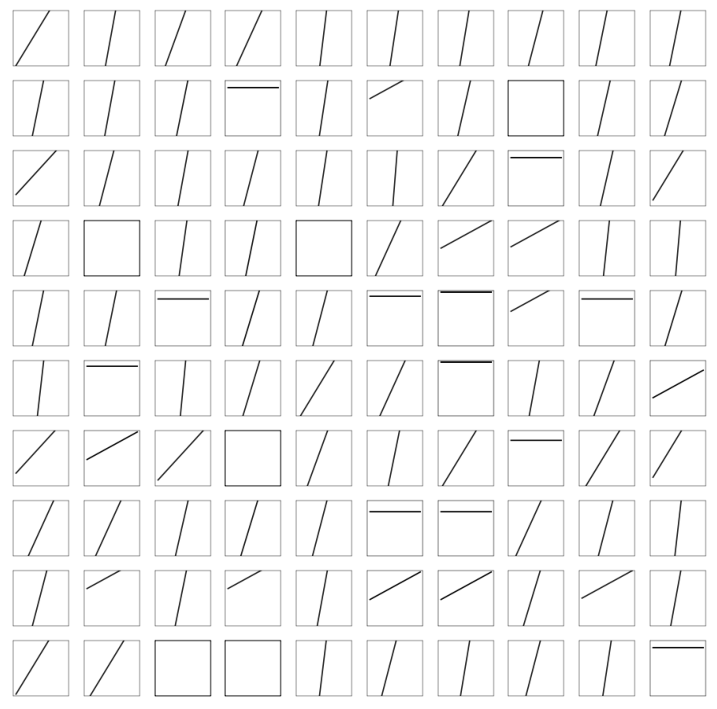

In [52]:
# num_samples = 25
sample_imgs = [i for i in imgs]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [53]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [60]:
dataset = TensorDataset(imgs)
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [61]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(76 * 77, 128),
            nn.ReLU(),
            nn.Linear(128, 76 * 77),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 76*77)
        logits = self.linear_relu_stack(x)
        return logits

In [62]:
model = NeuralNetwork().to(device)

In [63]:
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5852, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5852, bias=True)
    (3): Sigmoid()
  )
)


In [64]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [65]:
def train(data, model, loss_fn, optimizer, id):
    size = len(data)
    model.train()
    loss_total = 0

    for x in dataloader:
        x = x[0].to(device)
        
        pred = model(x)
        loss = loss_fn(pred, x.view(-1, 76*77))
        loss_total += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (id % 50 == 0):
        print(loss_total)
    

In [66]:
train(imgs, model, loss_fn, optimizer, 1)

In [67]:
for i in range(1000):
    train(imgs, model, loss_fn, optimizer, i)

11.491783246397972
11.313178688287735
10.648046612739563
8.160913407802582
2.4648525342345238
1.3716603498905897
1.2032803557813168
1.0964015685021877
1.0241758469492197
0.9924195483326912
0.9563262723386288
0.9456607066094875
0.9397257473319769
0.9140649996697903
0.8900800310075283
0.8732052408158779
0.8638731632381678
0.8560477755963802
0.8524438552558422
0.828323595225811


In [68]:
pred = model(imgs[0].to(device))

In [69]:
pred.view(76,77)

tensor([[1.0000, 0.9866, 0.9993,  ..., 0.9973, 1.0000, 1.0000],
        [0.9998, 0.9861, 0.9859,  ..., 0.9407, 0.9828, 0.9803],
        [0.9932, 0.9970, 0.9883,  ..., 0.8042, 0.9894, 0.9860],
        ...,
        [0.9840, 1.0000, 0.9875,  ..., 0.9907, 0.9929, 0.9923],
        [1.0000, 0.9895, 0.9847,  ..., 0.9992, 0.9831, 0.9834],
        [0.9998, 0.9884, 0.9971,  ..., 0.9985, 0.9932, 1.0000]],
       device='mps:0', grad_fn=<ViewBackward0>)

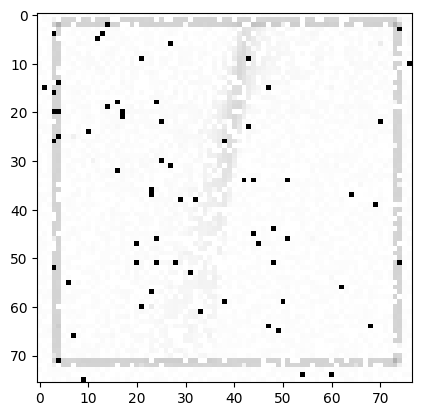

In [70]:
plt.imshow(pred.view(76,77).to("cpu").detach().numpy(), cmap='gray')

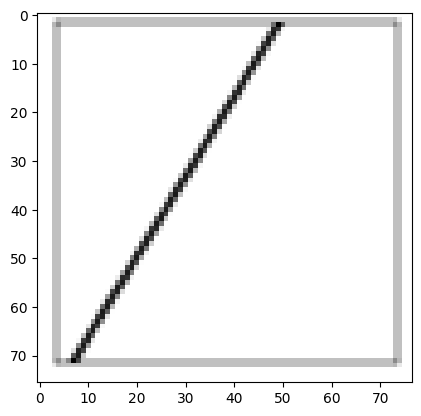

In [71]:
plt.imshow(imgs[0], cmap="gray")